# Assignment 1: Market Clearing (System Perspective)

### Import external libraries

In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from network import initialize_network, system_demand

## Step 0: Build a Relevant Case Study

Please select an electric power network from the following options:
1. IEEE 24-bus reliability test system: link.
2. IEEE reliability test system (2019 update): link.
3. IEEE power systems test cases (various cases with 14, 30, 57, 118, and 300 buses): link.
4. Case studies available in the open-source Julia platform PowerModels.jl: link.

You are also free to choose another case study. If some data is missing, please select reason-
able arbitrary values. For technical details on conventional generators and transmission lines, this link may be helpful (it corresponds to the IEEE 24-bus case study, but similar data can be used for other cases).

### IEEE 24-bus reliability test system

In [2]:
consumers, generators = initialize_network()
print(generators)
print(consumers)
print("Network initialized successfully.")

[Generator(unit=1, node=1), Generator(unit=2, node=2), Generator(unit=3, node=7), Generator(unit=4, node=13), Generator(unit=5, node=15), Generator(unit=6, node=15), Generator(unit=7, node=16), Generator(unit=8, node=18), Generator(unit=9, node=21), Generator(unit=10, node=22), Generator(unit=11, node=23), Generator(unit=12, node=23), Generator(unit=13, node=3), Generator(unit=14, node=5), Generator(unit=15, node=7), Generator(unit=16, node=16), Generator(unit=17, node=21), Generator(unit=18, node=23)]
[Consumer(load=1, node=1, share=0.038), Consumer(load=2, node=2, share=0.034), Consumer(load=3, node=3, share=0.063), Consumer(load=4, node=4, share=0.026), Consumer(load=5, node=5, share=0.025), Consumer(load=6, node=6, share=0.048), Consumer(load=7, node=7, share=0.044), Consumer(load=8, node=8, share=0.06), Consumer(load=9, node=9, share=0.061), Consumer(load=10, node=10, share=0.068), Consumer(load=11, node=13, share=0.093), Consumer(load=12, node=14, share=0.068), Consumer(load=13, 

### Additional Assumptions


*   Assume that the price bids of all producers are non-negative and equal to their marginal production cost. In particular, the production cost of renewable units is assumed to be zero. Additionally, these units offer their forecasted capacity, meaning their offer quantities vary over time.

*   For the bid price of price-elastic demands, use comparatively high values (relative to the generation cost of conventional units) to ensure that most demands are supplied. For inspiration, check the real bid price data in Nord Pool [link].
*   A potential source for wind power forecast data is available at this link (you may nor- malize the data to fit your case study). Another potential source for the renewable power generation data is renewables.ninja.
*   For transmission lines, you may assume a uniform reactance for all lines (e.g., 0.002 p.u., leading to a susceptance of 500 p.u.).

## Step 1: Copper-Plate, Single Hour

In Lecture 2, you learn how to develop a market-clearing optimization model for a copper-plate
power system (i.e., without modeling the transmission network) in a single-hour setting.
Please determine the following market-clearing outcomes:


### Qur Optimzation Problem


\begin{align}
\textrm{maximize} \quad
&13.32x_1 + 13.32x_2 + 20.7x_3 + 20.93x_4 + 26.11x_5 + 10.52x_6 \\
&\quad + 10.52x_7 + 6.02x_8 + 5.47x_9 + 0x_{10} + 10.52x_{11} + 10.89x_{12} \\
\textrm{subject to} \\
&0 \le  x_1 \le 152 \\
&0 \le x_1 \le 152 \\
&0 \le x_2 \le 152 \\
&0 \le x_3 \le 350 \\
&0 \le x_4 \le 591 \\
&0 \le x_5 \le 60 \\
&0 \le x_6 \le 155 \\
&0 \le x_7 \le 155 \\
&0 \le x_8 \le 400 \\
&0 \le x_9 \le 400 \\
&0 \le x_{10} \le 300 \\
&0 \le x_{11} \le 310 \\
&0 \le x_{12} \le 350 \\
& 2464.965 - \sum_{i=1}^{12} x_i = 0 \\
\end{align}


\begin{align}
\textrm{minimize} \quad 
&\sum_{i=1}^{12} C_i *x_i \\
\end{align}

\begin{align}
\textrm{where} \quad 
C_i = \textrm{offer price of generator i} \\
x_i =  \textrm{production of generator i} \\
\end{align}



### The market-clearing price under a uniform pricing scheme.

In [3]:
# define the demand time at 16:00
total_consumption_16 = system_demand[16]
print(f"Total consumption at 16:00 is {total_consumption_16} MW")
#check if all generators are there
id_Gnerators = []
for i in generators:
    id_Gnerators.append(i.unit_id)
print(id_Gnerators)

Total consumption at 16:00 is 2464.965 MW
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


Define the supply


In [4]:
#Variable generators costs 
generator_cost = []
for i in generators:
    generator_cost.append(i.cost_energy)
print(generator_cost)

#variable demand bids prize
demand_bids = []
#consumption for each consumer
consumption = []
for i in consumers:
    demand_bids.append(i.price)
    consumption.append(i.share * total_consumption_16)
print(demand_bids)
print(consumption)

if sum(consumption) == total_consumption_16:
    print("Aggregation correct")

[13.32, 13.32, 20.7, 20.93, 26.11, 10.52, 10.52, 6.02, 5.47, 0, 10.52, 10.89, 0, 0, 0, 0, 0, 0]
[165.0, 155.0, 175.0, 150.0, 145.0, 170.0, 160.0, 180.0, 185.0, 190.0, 210.0, 195.0, 220.0, 158.0, 215.0, 178.0, 162.0]
[93.66867, 83.80881000000001, 155.292795, 64.08909, 61.62412500000001, 118.31832000000001, 108.45846, 147.8979, 150.362865, 167.61762000000002, 229.241745, 167.61762000000002, 273.61111500000004, 86.27377500000001, 288.400905, 157.75776000000002, 110.92342500000001]
Aggregation correct


Define Generator capacity:

In [5]:
#Generators capacity
generator_capacity = []
for i in generators:
    generator_capacity.append(i.p_max)
print(generator_capacity)

[152, 152, 350, 591, 60, 155, 155, 400, 400, 300, 310, 350, 200, 200, 200, 200, 200, 200]


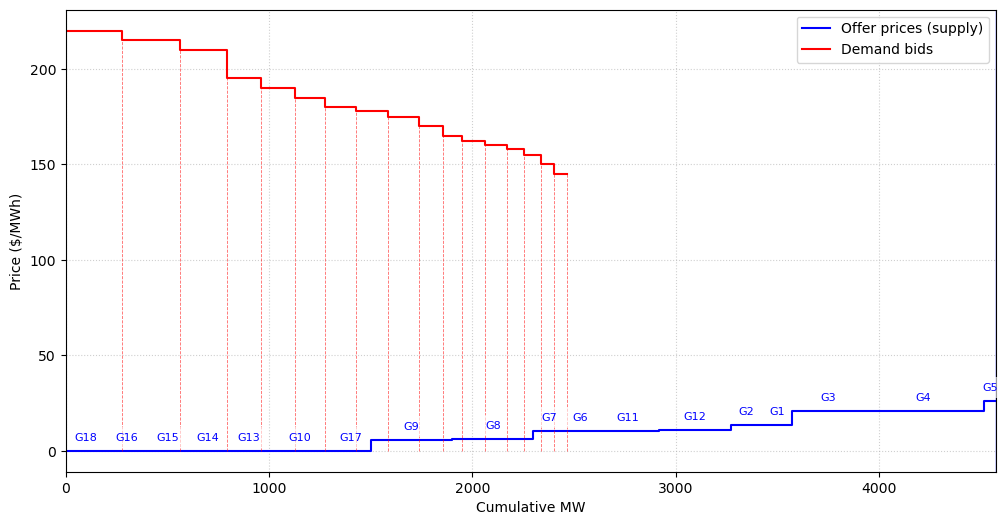

In [6]:

# supply (offers) staircase
# suppress inter-segment vertical lines and only draw the final boundary
_orig_axvline = plt.axvline
def _axvline_only_end(x, *args, **kwargs):
    try:
        if 'x_supply' in globals() and np.isclose(x, x_supply[-1]):
            # draw final supply boundary with same style as the supply step (solid blue)
            return _orig_axvline(x, color='blue', linestyle='-', linewidth=1, alpha=0.9)
    except Exception:
        pass
    # ignore other vertical lines (no dotted lines between steps)
    return None
plt.axvline = _axvline_only_end
costs = np.array(generator_cost)
caps = np.array(generator_capacity)
s_idx = np.argsort(costs)
s_costs = costs[s_idx]
s_caps = caps[s_idx]
x_supply = np.concatenate(([0], np.cumsum(s_caps)))
y_supply = np.concatenate((s_costs, [s_costs[-1]]))

# demand (bids) staircase (sorted descending)
bids = np.array(demand_bids)
qs = np.array(consumption)
d_idx = np.argsort(-bids)
d_bids = bids[d_idx]
d_qs = qs[d_idx]
x_demand = np.concatenate(([0], np.cumsum(d_qs)))
y_demand = np.concatenate((d_bids, [d_bids[-1]]))

plt.figure(figsize=(12,6))
plt.step(x_supply, y_supply, where='post', color='blue', label='Offer prices (supply)')
plt.step(x_demand, y_demand, where='post', color='red', label='Demand bids')

# annotate supply segments with generator id and capacity
max_price = max(y_supply.max(), y_demand.max())
for j in range(len(s_caps)):
    gen_idx = s_idx[j]                 # original generator index
    gen_id = id_Gnerators[gen_idx]     # generator unit id
    x0, x1 = x_supply[j], x_supply[j+1]
    # vertical boundary line
    plt.axvline(x0, color='gray', linestyle='--', linewidth=0.6, alpha=0.6)
    # label in middle of the segment
    plt.text((x0 + x1) / 2, y_supply[j] + 0.02 * max_price,
             f'G{gen_id}',
             ha='center', va='bottom', fontsize=8, color='blue', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# draw vertical lines from each demand step down to the x-axis
for j in range(len(d_qs)):
    x_bound = x_demand[j+1]
    y_lvl = d_bids[j]
    plt.vlines(x_bound, 0, y_lvl, color='red', linestyle='--', linewidth=0.6, alpha=0.6)

# mark final supply boundary
plt.axvline(x_supply[-1], color='gray', linestyle='--', linewidth=0.6, alpha=0.6)
# mark market-clearing price line if available
if 'balance_dual' in globals():
    plt.axhline(balance_dual, color='k', linestyle='--', linewidth=1, label=f'Market price = {balance_dual:.2f}')

plt.xlim(0, max(x_supply[-1], x_demand[-1]))
plt.xlabel('Cumulative MW')
plt.ylabel('Price ($/MWh)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

Everytime you use Gurobi, you will need to import the package ```gurobipy```. The specific module ```GRB``` is commonly imported separately, as it is used frequently. 

In [7]:
#create the optimization model
model = gp.Model("Economic_Dispatch_Model")

Set parameter Username
Set parameter LicenseID to value 2773996
Academic license - for non-commercial use only - expires 2027-02-02


In [8]:
production_variables = [
    model.addVar(lb=0, ub = float('inf') , vtype=GRB.CONTINUOUS, name=f"p_{i}")
    for i,v in enumerate(generator_capacity)
]

consumption_variables = [
    model.addVar(lb=0, ub = v , vtype=GRB.CONTINUOUS, name=f"p_{i}")
    for i,v in enumerate(consumption)
]

In [9]:
balance_constraint = model.addConstr(gp.quicksum(consumption_variables[i] for i,v in enumerate(consumption)) - gp.quicksum(production_variables[i] for i,v in enumerate(generator_capacity)) == 0, name="balance_constraint")
#balance_constraint = model.addConstr(gp.quicksum(production_variables[i] for i,v in enumerate(generator_capacity)) == total_consumption_16, name="balance_constraint")
capacaity_constraints = [model.addConstr(production_variables[i] <= generator_capacity[i], name=f"capacity_constraint_{i}") for i in range(len(generator_capacity))]


In [10]:
model.setObjective(
    gp.quicksum(consumption_variables[j] * demand_bids[j] for j in range(len(consumption_variables)))
    - gp.quicksum(generator_cost[i] * production_variables[i] for i in range(len(production_variables))),
    GRB.MAXIMIZE
)
#model.setObjective(
    #gp.quicksum(generator_cost[i] * production_variables[i] for i in range(len(production_variables))),
    #GRB.MINIMIZE
#)

In [11]:
model.optimize()

Gurobi Optimizer version 13.0.1 build v13.0.1rc0 (mac64[rosetta2] - Darwin 25.2.0 25C56)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 19 rows, 35 columns and 53 nonzeros (Max)
Model fingerprint: 0xc5388717
Model has 28 linear objective coefficients
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+02]
  Bounds range     [6e+01, 3e+02]
  RHS range        [6e+01, 6e+02]

Presolve removed 18 rows and 9 columns
Presolve time: 0.00s
Presolved: 1 rows, 26 columns, 26 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.6063294e+05   1.206206e+02   0.000000e+00      0s
       1    4.5430151e+05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.543015077e+05


In [12]:
#check status and print results 
if model.status == GRB.OPTIMAL:
    optimal_objective = model.objVal
    optimal_production_variables = [production_variables[i].x for i in range(len(generators))]
    optimal_consumption_variables = [consumption_variables[i].x for i in range(len(consumers))]
    balance_dual = balance_constraint.Pi
    # use the existing (typo) capacaity_constraints variable
    capacity_duals = [capacaity_constraints[i].Pi for i in range(len(generators))]

    print (f"Optimal objective value: {optimal_objective}")

    for index, optimal in enumerate(optimal_production_variables):
        print(f"Optimal production for Generator {id_Gnerators[index]:.2f}: {optimal} MW")

    for index, optimal in enumerate(optimal_consumption_variables):
        print(f"Optimal demand for Consumer {index}: {optimal:.2f} MW")

    print(f"Dual variable for balance constraint: {balance_dual:.2f}")

    for index, dual in enumerate(capacity_duals):
        print(f"Dual variable for capacity constraint of Generator {id_Gnerators[index]}: {dual}")

else:
    print(f"optimization of model {model.ModelName} was not successful. Status code: {model.status}")

Optimal objective value: 454301.50768
Optimal production for Generator 1.00: 0.0 MW
Optimal production for Generator 2.00: 0.0 MW
Optimal production for Generator 3.00: 0.0 MW
Optimal production for Generator 4.00: 0.0 MW
Optimal production for Generator 5.00: 0.0 MW
Optimal production for Generator 6.00: 0.0 MW
Optimal production for Generator 7.00: 0.0 MW
Optimal production for Generator 8.00: 400.0 MW
Optimal production for Generator 9.00: 400.0 MW
Optimal production for Generator 10.00: 300.0 MW
Optimal production for Generator 11.00: 164.96500000000015 MW
Optimal production for Generator 12.00: 0.0 MW
Optimal production for Generator 13.00: 200.0 MW
Optimal production for Generator 14.00: 200.0 MW
Optimal production for Generator 15.00: 200.0 MW
Optimal production for Generator 16.00: 200.0 MW
Optimal production for Generator 17.00: 200.0 MW
Optimal production for Generator 18.00: 200.0 MW
Optimal demand for Consumer 0: 93.67 MW
Optimal demand for Consumer 1: 83.81 MW
Optimal dema

In [13]:
print(f"The markets clearing price at 16:00 is: {balance_dual} $/MWh")

The markets clearing price at 16:00 is: 10.52 $/MWh


### The total operating cost and social welfare of the system.

In [14]:
total_coast = sum(optimal_production_variables[i] * balance_dual for i in range(len(optimal_production_variables)))
print(f"Total cost of generation at 16:00 is: {total_coast:.2f} $")
print(f"Social welfare at 16:00 is: {optimal_objective:.2f} $")

Total cost of generation at 16:00 is: 25931.43 $
Social welfare at 16:00 is: 454301.51 $


### The profit of each producer, including both conventional units and wind farms.

In [15]:
print(f"The production cost for each generator at 16:00 is:")
for i in range(len(generators)):
    cost = generator_cost[i] * optimal_production_variables[i]
    print(f"Generator {id_Gnerators[i]}: {cost:.2f} $")

The production cost for each generator at 16:00 is:
Generator 1: 0.00 $
Generator 2: 0.00 $
Generator 3: 0.00 $
Generator 4: 0.00 $
Generator 5: 0.00 $
Generator 6: 0.00 $
Generator 7: 0.00 $
Generator 8: 2408.00 $
Generator 9: 2188.00 $
Generator 10: 0.00 $
Generator 11: 1735.43 $
Generator 12: 0.00 $
Generator 13: 0.00 $
Generator 14: 0.00 $
Generator 15: 0.00 $
Generator 16: 0.00 $
Generator 17: 0.00 $
Generator 18: 0.00 $


### The utility of each demand, defined as:
$$

    \begin{align}
        \textrm{Utility = Power Consumption ×(Bid Price−Market-Clearing Price)}
    \end{align}

$$

In [16]:
for consumer in consumers:
    consuption = consumer.share * total_consumption_16
    bid_price = consumer.price
    utility = consuption * (bid_price - balance_dual)
    print(f"Consumer {consumer.load_id:.2f}: Consumption = {consuption:.2f} MW, Utility = {utility:.2f} $") 

Consumer 1.00: Consumption = 93.67 MW, Utility = 14469.94 $
Consumer 2.00: Consumption = 83.81 MW, Utility = 12108.70 $
Consumer 3.00: Consumption = 155.29 MW, Utility = 25542.56 $
Consumer 4.00: Consumption = 64.09 MW, Utility = 8939.15 $
Consumer 5.00: Consumption = 61.62 MW, Utility = 8287.21 $
Consumer 6.00: Consumption = 118.32 MW, Utility = 18869.41 $
Consumer 7.00: Consumption = 108.46 MW, Utility = 16212.37 $
Consumer 8.00: Consumption = 147.90 MW, Utility = 25065.74 $
Consumer 9.00: Consumption = 150.36 MW, Utility = 26235.31 $
Consumer 10.00: Consumption = 167.62 MW, Utility = 30084.01 $
Consumer 11.00: Consumption = 229.24 MW, Utility = 45729.14 $
Consumer 12.00: Consumption = 167.62 MW, Utility = 30922.10 $
Consumer 13.00: Consumption = 273.61 MW, Utility = 57316.06 $
Consumer 14.00: Consumption = 86.27 MW, Utility = 12723.66 $
Consumer 15.00: Consumption = 288.40 MW, Utility = 58972.22 $
Consumer 16.00: Consumption = 157.76 MW, Utility = 26421.27 $
Consumer 17.00: Consumpt

## Step 2: Copper-Plate, Multiple Hours

### Question 2.1: The market-clearing prices (one per hour) under a uniform pricing scheme.

In [ ]:
for i in range(24):
    i = i+1
    print(consumers[0].demand_time_series[i])

AttributeError: 'list' object has no attribute 'demand_time_series'